# __Tutorial 7: Use Fracture Domains to generate a DFN__

In this tutorial, we describe how to define Fracture Domains in a system. Fracture Domains will let us parametrize space with different properties for to each Fracture Domain.
<br>

At the end of this tutorial you will be able to:
* Add Fracture Domain to describe your system
* Create an Octree to speed up the access to the property of any point in the system
* Vizualise the Octree
* Get property to any point of the system

Prerequisites
:
* Creation of a DFN ([Tuto2](https://gitlab.com/fractorylab/dfnlab/-/blob/master/Tutorials/Tuto2_Generation_DFN_stochastic.ipynb))

In [1]:
import dfnlab.DFNIO as dfn_io
import dfnlab.GeometryLib as dfn_geo
import dfnlab.DFNBasis as dfn
import dfnlab.DataAnalysis as dfn_data

import os 

In [2]:
display = True

## Import the Volume from STL files and create a Fracture Domains from the extracted closed surfaces

You may not use opened surfaces to create a Fracture Domain

In [3]:
stlReaders = []
fractureDomains = []
for i in range (0,6) :
    fileName="./sources/volume"+str(i+1)+".stl"
    stlReaders.append(dfn_data.STLReader(fileName))
    stlReaders[i].reScale([5,30,60]) #Translate the volume
    fractureDomains.append(dfn.FractureDomain(stlReaders[i].getIrregularDomain()))

## Add properties to Fracture Domains
Here we add a density for each domain

In [4]:
fractureDomains[0].setProperties(dfn.DomainProperties(0.01))
fractureDomains[1].setProperties(dfn.DomainProperties(0.05))
fractureDomains[2].setProperties(dfn.DomainProperties(0.08))
fractureDomains[3].setProperties(dfn.DomainProperties(0.10))
fractureDomains[4].setProperties(dfn.DomainProperties(0.15))
fractureDomains[5].setProperties(dfn.DomainProperties(0.20))

## Create the System and add the Domains 

In [5]:
system = dfn.System()
system.buildParallelepiped([0, 0, 0], 120)
for i in range (0,6) :
    system.addFractureDomain(fractureDomains[i])

## Create an Octree
The Octree is a data structure that discretize the volume according to the fracture domains. We need to provide a default density and a depth limit (the refinement level of the octree, the larger, the more precise the discretization)
* Default density : the density for parts of the space not covered by domains
* DepthLimit : determine the size of our voxels (ie the precision of our space discretisation)




In [6]:
system.populateOctree(dfn.DomainProperties(0), 5)

## Access to the properties of a given point in the System
Now that we have created an Octree, we can directly get the property attached to that part of the system from the Octree


In [7]:
point = [12, 20, 48]
densityFromOctree = system.getProperties(point).getDensity()
print("The density at this point of space is: ",densityFromOctree)

The density at this point of space is:  0.05


## Create the VTP files

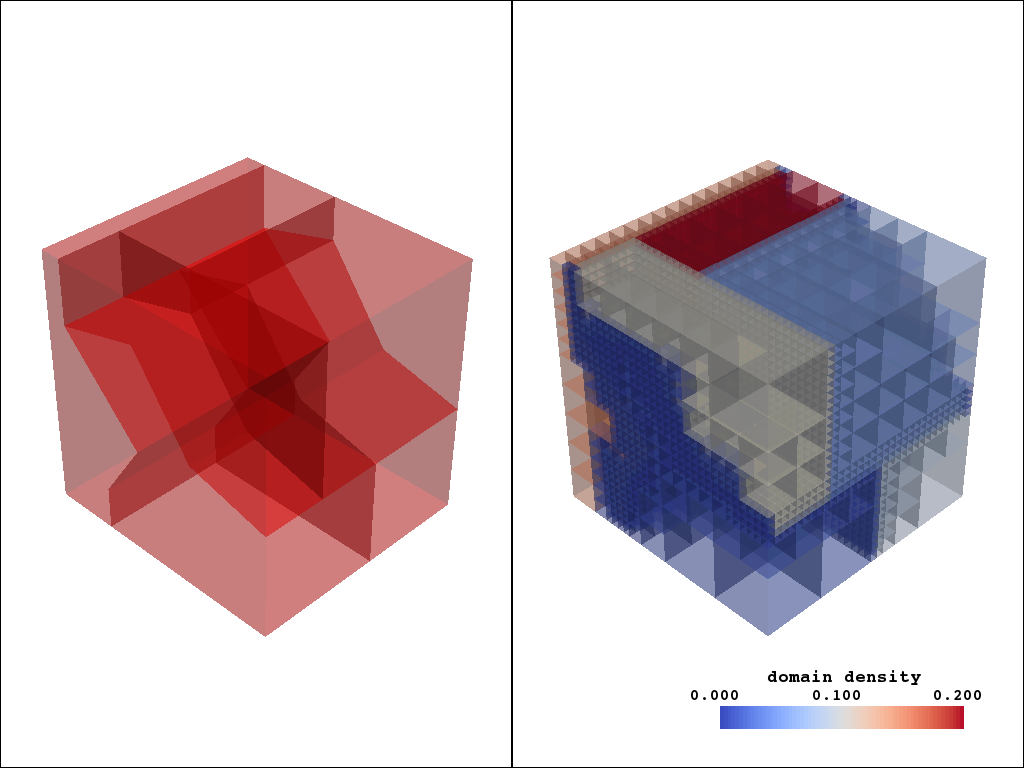

In [8]:
if display:
    path = os.getcwd()
    pathFolder = os.getcwd()+"/Tmp"
    if not os.path.isdir(pathFolder) :
        os.mkdir(pathFolder)
    fnet = dfn.DFN(system)    
    #Create a writer from our DFN
    writer = dfn_io.DFNIO_Object(fnet)
    #Write a VTP for the Domains
    writer.createVTKDataFractureDomains()
    writer.writeVTKOnFractureDomains(pathFolder+"/Domains.vtp");
    #Write a VTU for the Octree
    writer.createVTKDataOctree();
    writer.writeVTKOnOctree(pathFolder+"/Octree.vtu");    
    
    import pyvista as pv
    p = pv.Plotter(shape=(1,2), notebook=True)
    p.set_background('white')
    visu_octree = pv.read(pathFolder+"/Octree.vtu")
    argss = dict(color='black', n_labels = 3, title_font_size = 14, label_font_size=12)
    visu_domains = pv.read(pathFolder+"/Domains.vtp")
    p.subplot(0, 1)
    p.add_mesh(visu_octree, scalars='domain density', cmap='coolwarm',lighting=True, show_scalar_bar=True, scalar_bar_args=argss, opacity = 0.05)
    p.subplot(0, 0)
    p.add_mesh(visu_domains, color='red', show_edges=False, edge_color='white', lighting=True, show_scalar_bar=True, opacity=0.3)   
    p.show(auto_close=False, use_panel=False)


## How to use domains density to generate a DFN
The octree along with the associated densities for the domains can be used to generate a Poissonian DFN matching the defined properties in a similar way than the Tuto n°2.
In our case we do not need to provide a stop density as we already defined a density for each domain and a default density for rest of the system when we have populated the octree.
However we can choose other stop criteria if we want :
* p32 using setStopDensity()
* percolation using setStopPercolation()
* number of fracture using setStopNumber(number) 
In thes cases, density of domains is recalculated as a ratio of properties between domains.


In [9]:
import dfnlab.DFNGenerator as dfn_gen

fnet = dfn.DFN(system)    
generator = dfn_gen.PoissonGenerator(fnet,1001) #seed=1001
generator.setSizesPowerlaw(3.,1,100)
generator.setPositionsUniform()
generator.setOrientationsFisher(45,90,15)
generator.setStopPercolation()
generator.generateByDomains() # we use generateByDomains() where we use generate() in tuto2


True

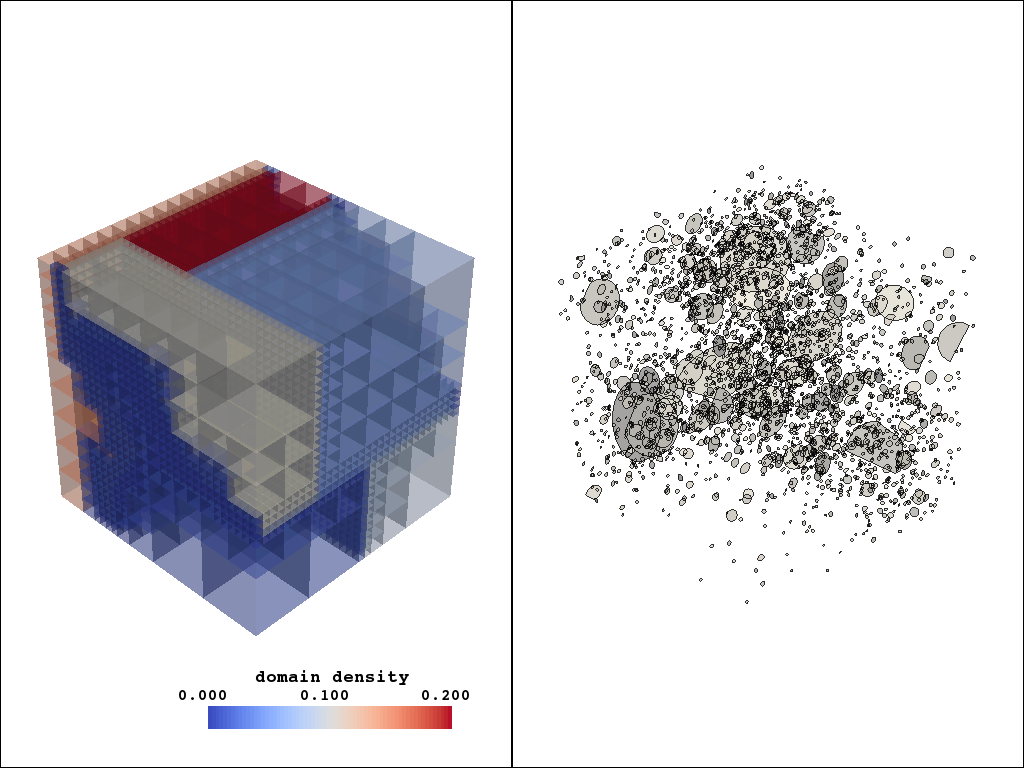

In [10]:
if display:
    import numpy as np
    path = os.getcwd()
    pathFolder = os.getcwd()+"/Tmp"
    if not os.path.isdir(pathFolder) :
        os.mkdir(pathFolder)
    fnet = generator.getDFN()
    #Create a writer from our DFN
    writer = dfn_io.DFNIO_Object(fnet)
    #Write a VTP for the DFN
    writer.createVTKDataDFN()
    writer.writeVTKOnDFN(pathFolder+"/dfn.vtp");
    #Write a VTU for the Octree
    writer.createVTKDataOctree();
    writer.writeVTKOnOctree(pathFolder+"/Octree.vtu");    
    
    p = pv.Plotter(shape=(1,2), notebook=True)
    p.set_background('white')
    visu_octree = pv.read(pathFolder+"/Octree.vtu")
    argss = dict(color='black', n_labels = 3, title_font_size = 14, label_font_size=12)
    visu_dfn = pv.read(pathFolder+"/dfn.vtp")
    p.subplot(0, 0)
    p.add_mesh(visu_octree, scalars='domain density', cmap='coolwarm',lighting=True, show_scalar_bar=True, scalar_bar_args=argss, opacity = 0.05)
    p.subplot(0, 1)
    p.add_mesh(visu_dfn, color='white', show_edges=True, edge_color='black', lighting=True, show_scalar_bar=True, opacity=0.8)
    p.show(auto_close=False, use_panel=False)